# Primitive model of electrolytes

In this example we explore the possibility for setting a background dielectric constant for simulating (soft) particles in an implicit solvent.

- Can $\epsilon_r$ be set for PME/Ewald? Nothing found in the documentation so far except for scaling charges
- Use a custom nonbonded ff instead?
- GBSA forces are automatically added when a `<GBSAOBCForce>` section is encountered in .xml file
- For ideas for rigid bodies, see openmm forum: https://simtk.org/forums/viewtopic.php?f=161&t=5841&p=14836&hilit=rigid#p14836

In [1]:
%matplotlib inline
from __future__ import print_function
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit
from sys import stdout, exit
import mdtraj as mdtraj
import numpy as np
import math

cutoff           = 10*unit.angstrom
useEwald         = True
useMinimize      = False
epsilon_r        = 80.
steps_eq         = 5000
steps_production = 2e5

pdb = app.PDBFile('nacl.pdb')
forcefield = app.ForceField('cg.xml')

if useEwald:
  suffix='_ewald'
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.Ewald, 
    nonbondedCutoff=cutoff, ewaldErrorTolerance=0.2)
else:
  suffix='_rf'
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.CutoffPeriodic, 
    nonbondedCutoff=cutoff)

# lower dielectric constant | scale charges
for i in system.getForces():
  if isinstance(i, mm.GBSAOBCForce):
    # do these have any effect?
    i.setSolventDielectric(epsilon_r)
    i.setSoluteDielectric(epsilon_r)
    print ('Solvent dielectric = ', i.getSolventDielectric())
    print ('Solute dielectric  = ', i.getSolventDielectric())
  if isinstance(i, mm.NonbondedForce):
    i.setReactionFieldDielectric(epsilon_r)
    print ('RF dielectric = ', i.getReactionFieldDielectric())
    for atom in pdb.topology.atoms():
      properties = i.getParticleParameters(atom.index)
      properties[0] = properties[0] / math.sqrt(epsilon_r)
      i.setParticleParameters(atom.index, *properties)
    
integrator = mm.LangevinIntegrator(
    300*unit.kelvin,
    1.0/unit.picoseconds, 
    20.0*unit.femtoseconds)

integrator.setConstraintTolerance(0.00001)

simulation = app.Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

if useMinimize:
  print('Minimizing...')
  simulation.minimizeEnergy()

print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
simulation.step(steps_eq)

steps_total = steps_eq + steps_production
simulation.reporters.append(mdtraj.reporters.HDF5Reporter('trajectory'+suffix+'.h5', 100))
simulation.reporters.append(app.PDBReporter('output'+suffix+'.pdb', 1000))
simulation.reporters.append(app.StateDataReporter(stdout, int(steps_total/10), step=True, 
    potentialEnergy=True, temperature=True, progress=True, remainingTime=False, 
    speed=True, totalSteps=steps_total, volume=True, separator='\t'))

print('Production...')
simulation.step(steps_production)

print('Done!')

RF dielectric =  80.0
Equilibrating...
Production...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Box Volume (nm^3)"	"Speed (ns/day)"
10.0%	20500	-12.6374067013	246.785037001	1000.0	0
20.0%	41000	-14.4823877315	360.528392849	1000.0	3.98e+03
30.0%	61500	-8.78702962864	390.258021678	1000.0	3.97e+03
40.0%	82000	-15.4160995354	340.751984141	1000.0	3.98e+03
50.0%	102500	-8.21784493457	273.25205338	1000.0	3.96e+03
60.0%	123000	-16.8425390769	306.227808744	1000.0	3.95e+03
70.0%	143500	-12.424594084	329.935178247	1000.0	3.95e+03
80.0%	164000	-11.9639682514	337.165881525	1000.0	3.94e+03
90.0%	184500	-10.4308637904	341.339662853	1000.0	3.93e+03
100.0%	205000	-7.01769777131	334.070820562	1000.0	3.94e+03
Done!


### Plot and compare with Debye-Hückel

Calculate the radial distribution function, $g(r)=\exp\left(-w(r)/k_BT\right)$, between Na+ and Cl- and compare
the result with the Debye-Hückel potential,

$w(r) / k_BT = \frac{\lambda_Bz_1z_2}{r}e^{-r/\lambda_D}$

where $\lambda_B$ and $\lambda_D$ are the Bjerrum and Debye lengths, respectively. As can be seen, even fairly crude Ewald parameters, short sampling, and large time steps give very good agreement.

conc    =  0.0398529307959 M
1/kappa =  15.2280204402 angstrom


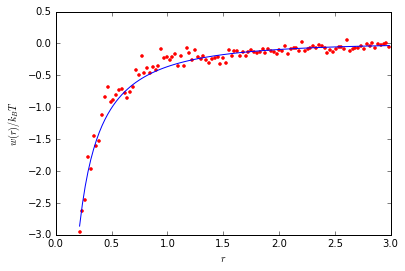

In [5]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from simtk.unit import sqrt

# volume, conc., debye length
n = simulation.system.getNumParticles() / unit.AVOGADRO_CONSTANT_NA
V = simulation.topology.getUnitCellDimensions()[0]**3
C = (n/V).in_units_of(unit.molar)
D = 3.04 / unit.sqrt(C.value_in_unit(unit.molar)) * 0.1

print('conc    = ', C)
print('1/kappa = ', D*10, 'angstrom')

# open trajectory and plot rdf
simulation.reporters[0].close()
traj = mdtraj.load('trajectory'+suffix+'.h5')
r,g = mdtraj.compute_rdf(traj, traj.topology.select_pairs('name Na', 'name Cl'),\
                         r_range=[0.2,3], bin_width=0.025)

# plot simulated Na-Cl pmf (red) vs. Debye-Huckel (blue)
plt.xlabel('$r$')
plt.ylabel('$w(r)/k_BT$')
plt.plot(r, -np.log(g), 'r.')
plt.plot(r, -0.7/r*np.exp(-r/D), '-')